# Лабораторная работа №7. Использование построенного пайплайна для многомерной  регрессии.
## Шкуратова Д.В. МКТ

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Данные

Набор данных включает в себя информацию о проданных домах за 2012-2013 год



In [2]:
df = pd.read_csv('Real estate.csv')
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [3]:
df.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [4]:
df = df.drop(['No'], axis=1)

<Axes: >

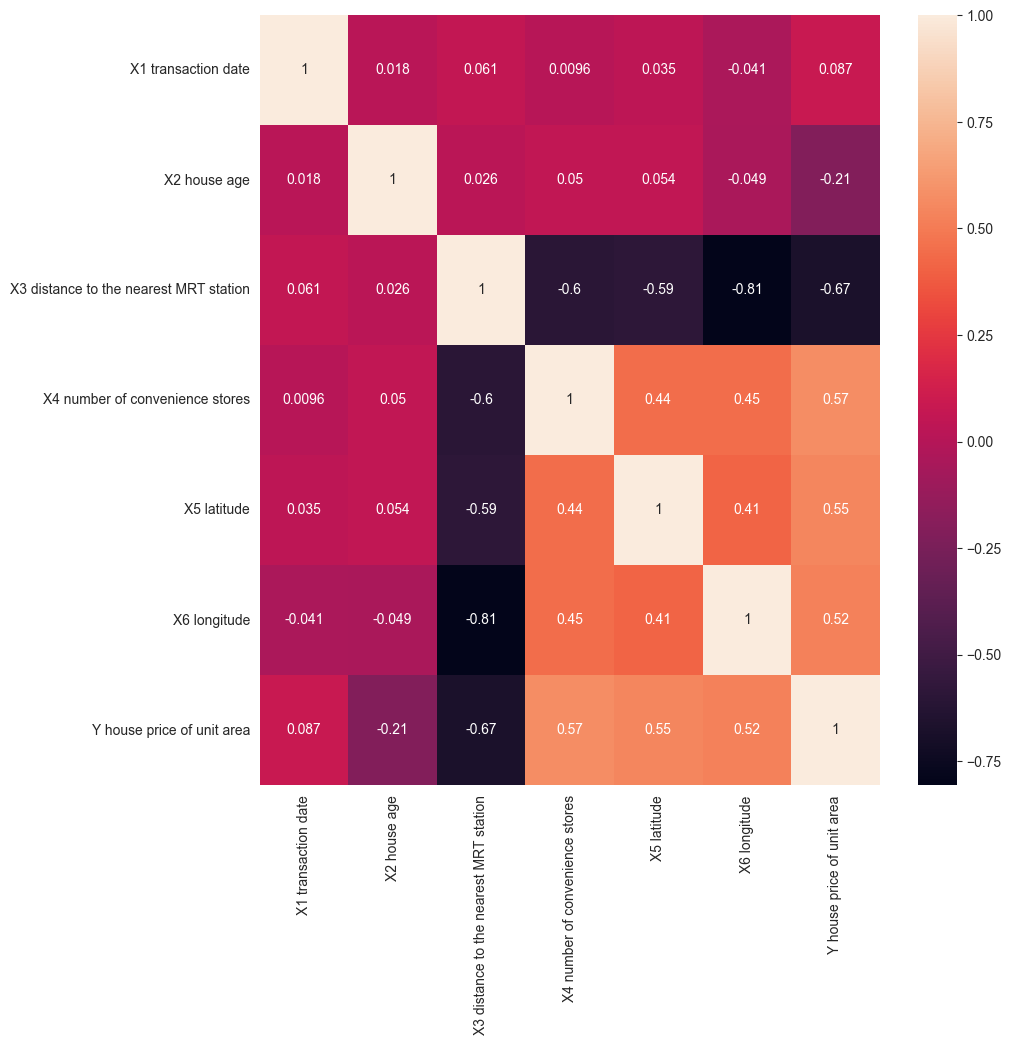

In [5]:
fig = plt.figure(figsize=(10, 10)) 
sns.heatmap((df.iloc[:,:len(df) - 1]).corr(numeric_only=True), annot=True)

Некоторые независимые переменные сильно скоррелированы друг с другом, условие теоремы Гаусса-Маркова не выполняется по этому пункту, но часто линейную регрессию строят, чтобы определить: есть ли связь между наблюдаемыми значениями? 

Рассмотрим попарный график и построим модель множественной регрессии методом Backward Elimination

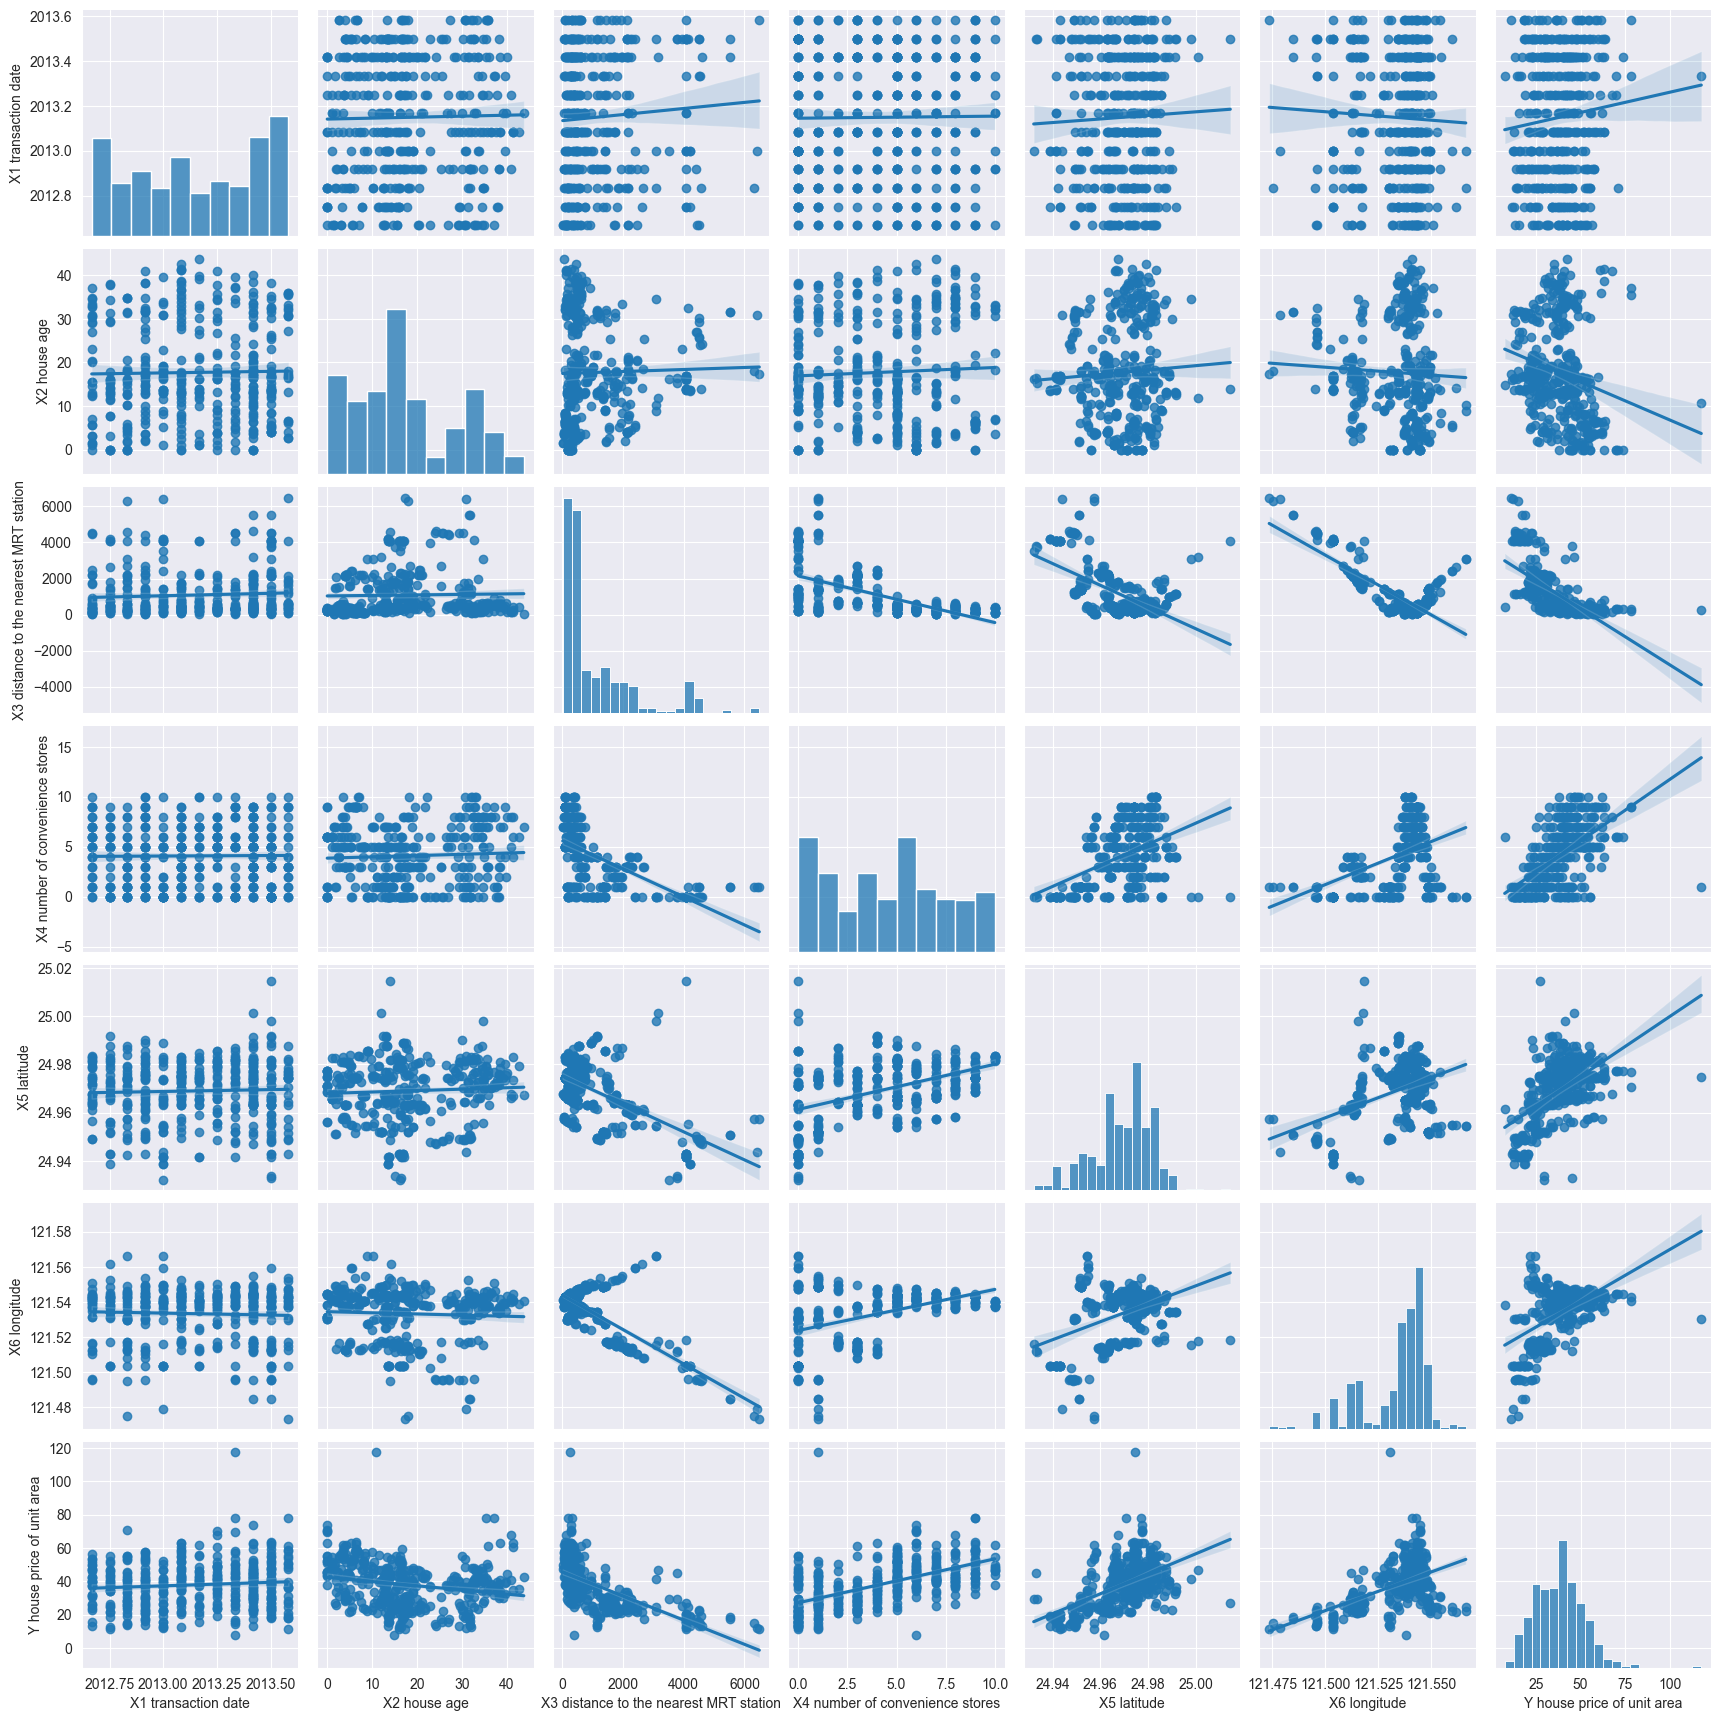

In [6]:
sns.pairplot(data=df, kind='reg')

По столбцу цены на дом видим, что ни одна независимая переменная не имеет линейной связи с моделируемым значением.

Также в данных есть проблема - не сильно отличающимся/равным значениям независимых переменных, соответствует несколько значительно отличающихся значений y  

## Метод построения модели - Backward Elimination
Построим модель линейной регрессии с помощью пакета statsmodels, последовательно исключая незначимые коэффициенты: гипотеза о равенстве коэффициента $\beta_i$ нулю при независимой переменной $x_i$ не отвергается. 

In [7]:
# Проверим нет ли в данных пропусков
df.isna().sum()

X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

In [8]:
y = np.array(df.iloc[:, 6:7].values)
x = np.array(df.iloc[:, :6].values)


#### Алгоритм для автоматического удаления статистически незначимых коэффициентов

In [9]:
import statsmodels.api as sm
# Добавляем столбец свободных членов
x = np.append(arr = np.ones((len(y),1)).astype(int), values=x, axis=1)


lst = list(range(7))
# Уровень значимости, с которым будем сравнивать p-значение
alpha = 0.05
# Массив с результатами построения на каждом шаге
k = []
while len(lst) > 1:
    x_opt = x[:, lst]
    regressor_OLS = sm.OLS(endog=y, exog=x_opt).fit()
    flag = False
    k.append(regressor_OLS.summary())
    # Проверяем для каких коэффициентов H_0 не отвергается и удаляем их из списка столбцов
    for i, j in enumerate(regressor_OLS.pvalues[1:]):
        if j >= alpha:
            lst.pop(i)
            flag = True
    if not flag:
        break
        
        
lst, len(k)

([0, 1, 2, 6], 4)

За 4 итерации отсеялись все статистически незначимые коэффициенты

Среди статистически значимых остались: Дата покупки, возраст дома и расстояние до ближайшего метро

Индекс 6 - столбец со свободной единицей

Свободный член при построении модели линейно регрессии нужен для оценки влияния параметров, не включенных в модель. Это позволяет лучше делать предсказания по построенной модели.



In [10]:
k[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     94.59
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           4.86e-74
Time:                        18:33:57   Log-Likelihood:                -1487.0
No. Observations:                 414   AIC:                             2988.
Df Residuals:                     407   BIC:                             3016.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.444e+04   6775.671     -2.131      0.034   -2.78e+04   -1117.421
x1             5.1462      1.557      3.305      0.001       2.085       8.207
x2            -0.2697      0.039     -7.000      0.000      -0.345      -0.194
x3            -0.0045      0.001     -6.250      0.000      -0.006      -0.003
x4             1.1333      0.188      6.023      0.000       0.763       1.503
x5           225.4730     44.567      5.059      0.000     137.863     313.083
x6           -12.4236     48.582     -0.256      0.798    -107.927      83.079
==============================================================================
Omnibus:                      231.634   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3599.138
Skew:                           2.026   Prob(JB):                         0.00
Kurtosis:                      16.865   Cond. No.                     3.72e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Как можно рассматривать оценку коэффициентов $\beta_i$   $i = \overline{1, 6}$ 

1. Посмотреть на построенные доверительные интервалы: если они включают 0, то гипотеза $H_0$ не отвергается. На  нашем примере 0 включает доверительный интервал для $x_6$

2. P-value Мы отклоняем гипотезу, что $beta_i = 0$, если p-value больше выбранного уровня значимости $\alpha$
В методе пакета statsmodels по умолчанию уровень значимости $\alpha = 0.05$, следовательно для применения нашего метода выбора значимых коэффициентов оставляем те, у которых $p-value < 0.05$, удаляем $x_6$ 

На большом количестве наблюдений любой коэффициент может оказаться значимым, так как регрессия схватывает любое, даже небольшое, отличие

In [11]:
k[1]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     102.2
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           1.02e-69
Time:                        18:33:57   Log-Likelihood:                -1499.6
No. Observations:                 414   AIC:                             3011.
Df Residuals:                     408   BIC:                             3035.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6437.9538   6784.301     -0.949      0.343   -1.98e+04    6898.594
x1             5.8037      1.598      3.633      0.000       2.663       8.945
x2            -0.2559      0.040     -6.466      0.000      -0.334      -0.178
x3            -0.0060      0.001     -8.792      0.000      -0.007      -0.005
x4             1.2454      0.192      6.473      0.000       0.867       1.624
x5           -42.8029     49.641     -0.862      0.389    -140.388      54.782
==============================================================================
Omnibus:                      211.039   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2867.908
Skew:                           1.826   Prob(JB):                         0.00
Kurtosis:                      15.366   Cond. No.                     3.61e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Статистическая незначимость $x_5$ выявляется по двум способам

In [12]:
k[2]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     106.6
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           3.74e-62
Time:                        18:33:57   Log-Likelihood:                -1519.8
No. Observations:                 414   AIC:                             3050.
Df Residuals:                     409   BIC:                             3070.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4706.3905   7109.873     -0.662      0.508   -1.87e+04    9270.063
x1             6.4063      1.673      3.830      0.000       3.118       9.695
x2            -0.2361      0.041     -5.705      0.000      -0.317      -0.155
x3            -0.0080      0.001    -12.593      0.000      -0.009      -0.007
x4           -66.9745     51.917     -1.290      0.198    -169.031      35.082
==============================================================================
Omnibus:                      150.816   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1190.617
Skew:                           1.332   Prob(JB):                    2.89e-259
Kurtosis:                      10.869   Cond. No.                     3.61e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
k[3]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     64.53
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           3.40e-34
Time:                        18:33:57   Log-Likelihood:                -1587.6
No. Observations:                 414   AIC:                             3183.
Df Residuals:                     410   BIC:                             3199.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.675e+04   6031.410    -11.067      0.000   -7.86e+04   -5.49e+04
x1             5.4091      1.966      2.751      0.006       1.544       9.274
x2            -0.2238      0.049     -4.597      0.000      -0.319      -0.128
x3           459.9577     36.158     12.721      0.000     388.879     531.036
==============================================================================
Omnibus:                       90.489   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              687.982
Skew:                           0.690   Prob(JB):                    4.04e-150
Kurtosis:                       9.163   Cond. No.                     2.20e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Модель плохо описывает данные, но мы смогли выявить статистически значимые независимые переменные для построения модели по предсказанию цен на дома.
Можно посмотреть на $R^2$ на разных шагах, $R^2$ является плохой метрикой для оценки точности множественной линейной регрессии, так как чем больше независимых переменных и чем больше выборка, тем выше коэффициент детерминации.
